Para este análisis se usó un conjunto de datos en el que se detallan los obsequios a funcionarixs públicxs registradxs en el ámbito de la Oficina Anticorrupción.
<a href="https://datos.gob.ar/dataset/justicia-registro-obsequios-funcionarios-publicos" target="_blank">Fuente de datos</a><br/><br/>
**Abarca el rango de 10/02/2017 a 08/10/2020.**

La Ley 25.188 de Ética en el Ejercicio de la Función Pública prohíbe a los funcionarios recibir obsequios o donaciones, con motivo o en ocasión del desempeño de sus funciones. <br/><br/>

Como excepción, pueden recibir aquellos obsequios que sean entregados por razones de cortesía o costumbre diplomática, pero sólo bajo las circunstancias establecidas en la referida ley y en el Decreto 1179/16 (Régimen de Obsequios a Funcionarios Públicos).<br/><br/>

Por su parte, todos los obsequios –admitidos por la ley 25.188- deben ser registrados y –cuando superan cierto valor (más de 4 módulos) o poseen significación institucional-, deben ser incorporados al patrimonio del Estado. <br/><br/>

Según el <a target="_blank" href="https://desafiospublicos.argentina.gob.ar/normativa/nacional/decreto-1030-2016-265506/texto">Decreto 1030/2016</a>, el valor del módulo (M) será de PESOS UN MIL ($ 1.000).


In [165]:
#importamos las librerías que vamos a necesitar
import io
import pandas as pd
import matplotlib.pyplot as plt
import re
import spacy
import os
import numpy as np
import fuzzywuzzy

from fuzzywuzzy import process
from os import path
from spacy.lang.es import Spanish
from spacy.lang.es.stop_words import STOP_WORDS
from wordcloud import WordCloud
from collections import Counter

In [166]:
# guardamos la ubicación para luego guardar imágenes que vamos a generar
d = path.dirname(__file__) if "__file__" in locals() else os.getcwd()

data = pd.read_csv("./data/registro-obsequios-funcionarios-publicos-20201009.csv")
print('Cantidad de registros cargados: {}'.format(len(data)))

Cantidad de registros cargados: 3928


In [167]:
# limpieza y unificación de features
data["funcionario_nombre"] = data["funcionario_nombre_completo"].apply(str.title) + " " + data["funcionario_apellido_completo"].apply(str.title)
data["obsequio_descripcion"] = data["obsequio_descripcion"].str.lower()

In [168]:
def replace_matches_in_column(df, column, string_to_match, min_ratio=90):
    strings = df[column].unique()
    
    # obtener el top 10 de similitudes más cercanas al string que estamos analizando
    matches = fuzzywuzzy.process.extract(string_to_match, strings, limit=10, scorer=fuzzywuzzy.fuzz.token_sort_ratio)

    # filtramos y nos quedamos sólo con las coincidencias con un ratio > 90
    close_matches = [matches[0] for matches in matches if matches[1] >= min_ratio]

    rows_with_matches = df[column].isin(close_matches)
    df.loc[rows_with_matches, column] = string_to_match

Al ver los nombres de funcionarixs, podemos notar que hay "repetidxs", ya sea por diferente cantidad de espacios entre palabras, por uso (o no) de tildes y otras razones. <br/>
Para verificar ésto (y arreglarlo) vamos a usar <a href="https://github.com/seatgeek/fuzzywuzzy" target="_blank">fuzzywuzzy</a>. <br/><br/>
En la celda siguiente veremos cuántos nombres parecidos a "Matías Daniel Lammens Núñez". <br/>
El número que aparece junto a la variante del nombre es el porcentaje de similitud (se pueden elegir diferentes métodos para analizar cuan similares son, en este caso elegimos `token_sort_ratio`).

In [169]:
df = data["funcionario_nombre"].unique()
df.sort()

matches = fuzzywuzzy.process.extract("Alberto Angel Fernandez", df, limit=10, scorer=fuzzywuzzy.fuzz.token_sort_ratio)
print(matches)

[('Alberto Angel Fernandez', 100), ('Alberto Angel Fernadez', 98), ('Alberto Angel Fernandwz', 96), ('Alberto Fernandez', 85), ('Alberto Gowland', 68), ('Alberto  Jorge Triaca', 60), ('Alberto Jorge Triaca', 60), ('Alejandro Hernan Amor', 59), ('Fernando Alvarez De Celis', 58), ('Fernando Benito Stabile', 57)]


In [170]:
print('Cantidad de nombres de funcionarixs')
print('Antes de la limpieza: {0}'.format(len(df)))

names_to_replace = [{"name": "Alberto Angel Fernandez", "min_ratio":80}, {"name": "Germán Carlos Garavano", "min_ratio":84}, {"name": "Matías Daniel Lammens Núñez", "min_ratio":67}, {"name":"Patricia Bullrich" , "min_ratio":75}]

for item in names_to_replace:
    replace_matches_in_column(df=data, column='funcionario_nombre', string_to_match=item.get("name"), min_ratio=item.get("min_ratio"))

names_to_replace = ["Agustin Dellagiovanna", "Alberto Jorge Triaca", "Carlos Vicente Ruá", "Cristina E. Fernández O Néstor C. irchner", "Cristián Roberto Dellepiane Rawson", "Damián Eduardo Arabia", "Dante Sica", "Fernando Félix Grasso", "Gustavo José Santos", "José Lino Salvador Barañao", "Marcelo Gabriel Suárez Salvia", "Maria Inés Baque", "Marta Gabriela Michetti", "María Eugenia Bielsa", "María Lara González Carvajal", "Ramón Lanús", "Ramón María Lanús", "Ricardo Agustín Campero", "Roberto Salvarezza", "Rogelio Frigerio", "Santiago Tomás Bellomo", "Mauricio Macri"]

for name in names_to_replace:
    replace_matches_in_column(df=data, column='funcionario_nombre', string_to_match=name)

df = data["funcionario_nombre"].unique()
df.sort()
print('Después de la limpieza: {0}'.format(len(df)))

Cantidad de nombres de funcionarixs
Antes de la limpieza: 366
Después de la limpieza: 326


In [171]:
#considerando que también hay varios roles con nombres similares..  necesitamos unificarlos
data["funcionario_funcion"] = data["funcionario_funcion"].str.lower()
data["funcionario_funcion"] = data["funcionario_funcion"].str.strip()

def cleanTxt(text):
 text = text.replace("registro de obsequios- señor presidente de la nación",'señor presidente de la nación')
 text = text.replace("hija de la señora de macri", "hija de la señora primera dama, srita valentina barbier")
 text = text.replace("hija del presidente de la nación de la nación, srita. antonia macri", "hija del presidente de la nación, srita. antonia macri")
 text = text.replace("vicepreseidencia",'vicepresidente')
 text = text.replace("presiente",'presidente')
 return text

data["funcionario_funcion"] = data.funcionario_funcion.apply(cleanTxt)

In [172]:
# Tomado prestado de José https://github.com/casanovajose/lo_regalito
def obsequiador_name(row):
  name = []
  data = []
  nombre = row["obsequiador_nombre_completo"]
  apellido = row["obsequiador_apellido_completo"]    
  razon_social = row["obsequiador_razon_social"]
  organismo = row["obsequiador_organismo"]
  descripcion = row["obsequiador_descripcion"]  
  if type(nombre) == str:
      name.append(nombre)
      
  if type(apellido) == str:
      name.append(apellido)
      
  name = " ".join(name)
  name = name.strip()  
  if type(razon_social) == str:
      data.append(razon_social)
      
  if type(organismo) == str:
      data.append(organismo)  
  if type(descripcion) == str:
      data.append(descripcion)  
  if len(name) > 0:
      data.insert(0, name)

  return " | ".join(data)

data["obsequiador_nombre"] = data.apply(obsequiador_name, axis=1)

In [173]:
# Uso este código para chequear roles similares y determinar el min_ratio que debería usar para reemplazar lo que quiero reemplazar
df = data["funcionario_funcion"].unique()
matches = fuzzywuzzy.process.extract("presidente", df, limit=10, scorer=fuzzywuzzy.fuzz.token_sort_ratio)
print(matches)

[('presidente', 100), ('presidente.', 100), ('vicepresidente', 83), ('presidente - aabe', 80), ('presidente aabe', 80), ('vicepresidenta', 75), ('presidente de nación', 69), ('presidente de la nación', 62), ('presidente de la  nación', 62), ('presidente de la naciòn', 62)]


In [174]:
df = data["funcionario_funcion"].unique()
df.sort()
print('Cantidad de roles de funcionarixs')
print('Antes de la limpieza: {0}'.format(len(df)))

roles_to_replace = [{"role": "ministra de relaciones exteriores y culto", "min_ratio": 85}, {"role": "ministro de producción y trabajo", "min_ratio": 80}, {"role": "secretario general de la presidencia de la nación", "min_ratio": 80}, {"role": "señora primera dama", "min_ratio": 65}, {"role": "subsecretario", "min_ratio": 88}, {"role": "titular", "min_ratio": 70}, {"role": "ministra de seguridad", "min_ratio":78}, {"role": "ministro de educación y deportes de la nación", "min_ratio": 84}, {"role": "hija de la señora primera dama, srita valentina barbier", "min_ratio": 62}, {"role": "ministro de educación, cultura, ciencia y tecnología", "min_ratio": 85}, {"role": "ministro de agricultura, ganadería y pesca de la nación", "min_ratio": 85}, {"role": "secretario de coordinación de políticas públicas", "min_ratio": 79}, {"role": "jefa del dpto de priv, e inmun, acred. y guía diplo", "min_ratio": 82}, {"role": "presidencia de la nación", "min_ratio": 87}, {"role": "hija del presidente de la nación, srita. antonia macri", "min_ratio": 75}, {"role": "secretario de relaciones exteriores", "min_ratio": 97}, {"role": "presidente", "min_ratio": 100}]

for item in roles_to_replace:
    replace_matches_in_column(df=data, column='funcionario_funcion', string_to_match=item.get("role"), min_ratio=item.get("min_ratio"))

roles_to_replace = ["jefe de gabinete de ministros", "directora nacional de ética pública", "ministro de turismo y deportes", "ministro de turismo", "secretaría de ética pública transparencia y lucha contra la corrupción", "secretaria de relaciones políticas y parlamentarias", "secretario de economía social", "secretario de gobierno de energia", "secretario de seguridad interior", "subsecretario de política exterior", "coordinador de relaciones institucionales con dependencia directa del ministerio de produccion", "coordinador/a general", "ministra de seguridad de la nación", "jefa de gabinete", "presidente - aabe", "secretario de agricultura, ganadería y pesca", "supervisor de fiscalización", "vicepresidente de la nación"]

for role in roles_to_replace:
    replace_matches_in_column(df=data, column='funcionario_funcion', string_to_match=role)

df = data["funcionario_funcion"].unique()
df.sort()
print('Después de la limpieza: {0}'.format(len(df)))

Cantidad de roles de funcionarixs
Antes de la limpieza: 294
Después de la limpieza: 214


In [175]:
def make_wordcloud(data, filename=None):
    wc = WordCloud(background_color="white", width=1000, height=500).generate_from_frequencies(data)
    plt.figure(figsize=(15,8))
    plt.imshow(wc)
    plt.axis("off")
    plt.show()
    if filename:
        wc.to_file(path.join(d, filename+".png"))

                                                                       regalos
funcionario_nombre          funcionario_funcion                               
Mauricio Macri              Presidencia De La Nación                      1532
Alberto Angel Fernandez     Presidencia De La Nación                       188
Germán Carlos Garavano      Ministro                                       119
Jorge Faurie                Ministra De Relaciones Exteriores Y Culto      106
Rogelio Frigerio            Ministro                                        94
Susana Malcorra             Ministra De Relaciones Exteriores Y Culto       70
Mauricio Macri              Señora Primera Dama                             67
Marcos Peña                 Jefe De Gabinete De Ministros                   67
Alberto Jorge Triaca        Ministro                                        57
Matías Daniel Lammens Núñez Ministro De Turismo Y Deportes                  53


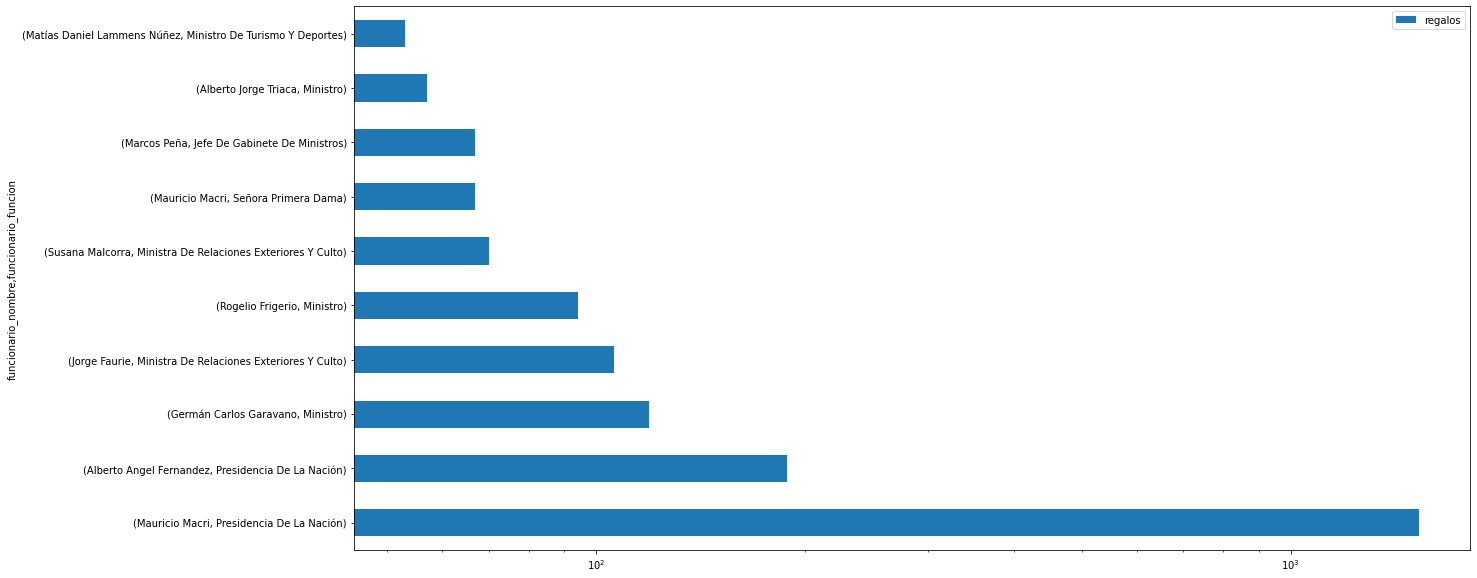

In [176]:
# como inicialmente convertimos los roles a minúsculas para "limpiarlos y unificarlos".. ahora los volvemos a convertir a CamelCase
data["funcionario_funcion"] = data["funcionario_funcion"].str.title()
gifts_received_by_role = data[["funcionario_nombre","funcionario_funcion"]].value_counts().to_frame('regalos')

#FIXME
# creo que para que las comparaciones sean más objetivas haría cantidad de regalos / cantidad de tiempo (dias?) en el cargo 
# sino alguien que estuvo en el cargo 4 años quizás tuvo 200 regalos, y el que estuvo en el cargo dos meses tuvo 150 regalos queda abajo. 


print(gifts_received_by_role.head(10))
gifts_received_by_role.head(10).plot(kind = 'barh', figsize=(20,10), logx=True)
plt.show()

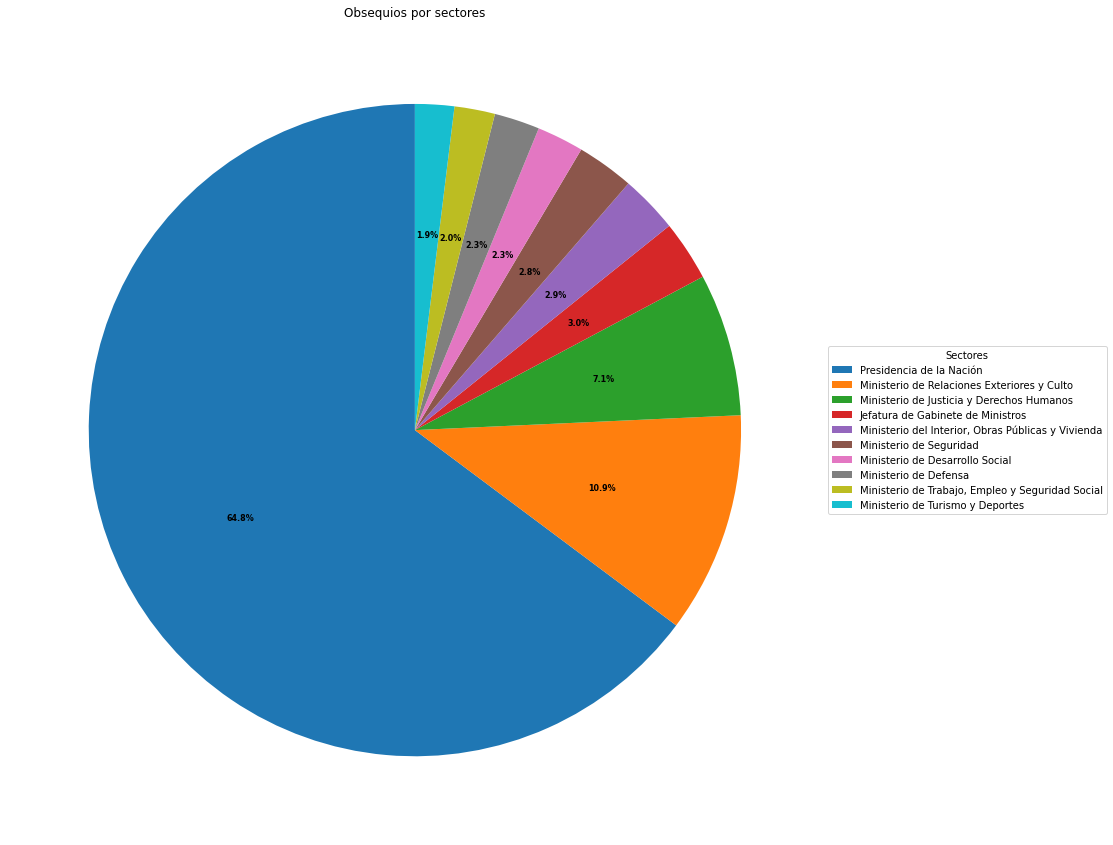

In [213]:
gifts_received_by_minister = data["funcionario_jurisdiccion"].value_counts().head(10)
labels = gifts_received_by_minister.keys()
values = gifts_received_by_minister.values

fig, ax = plt.subplots(figsize=(20, 15), subplot_kw=dict(aspect="equal"))
wedges, texts, autotexts = ax.pie(values, startangle=90, autopct='%1.1f%%')
ax.legend(wedges, labels, title="Sectores", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))
plt.setp(autotexts, size=8, weight="bold")
ax.set_title("Obsequios por sectores")
plt.show()

Al ver estos números, nos surgió la intriga de quiénes eran las personas que ocupaban cargos de ministrxs sin indicar el área en que trabajan y que recibieron tantos regalos como para estar en el top 10.

Según Wikipedia:
* **Germán Garavano** se desempeñó como  ministro de Justicia y Derechos Humanos de la República Argentina desde el 10 de diciembre de 2015 hasta el 9 de diciembre de 2019

* **Rogelio Frigerio** ocupó el cargo de Ministro del Interior, Obras Públicas y Vivienda del gobierno de Mauricio Macri desde el 10 de diciembre de 2015 hasta el 10 de diciembre de 2019.

* **Alberto Jorge Triaca** fue nombrado ministro de Trabajo en 2015 por Mauricio Macri,​ cargo que ocupó hasta 2018 cuando fue degradado a secretario de Trabajo del ministerio de Producción tras una reestructuración del gabinete.

Lxs 20 funcionarixs que más regalos recibieron


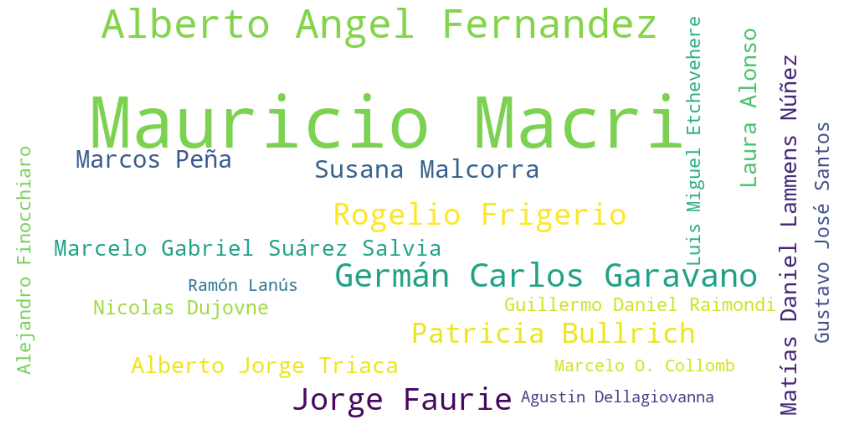

In [178]:
print("Lxs 20 funcionarixs que más regalos recibieron")
gift_by_func_counter = Counter(data.funcionario_nombre)
make_wordcloud(dict(gift_by_func_counter.most_common(20)))
#use it to save wordcloud as a file
#make_wordcloud(dict(gift_by_func_counter.most_common(20)), "roles_more_received_gifts_wordcloud") 

## (Anti) Conclusiones

In [238]:
print("¿Quiénes le hicieron obsequios a Mauricio Macri y a Alberto Fernandez?")
gifts_to_mmacri = data.loc[data["funcionario_nombre"] == "Mauricio Macri", "obsequiador_nombre"].unique()
gifts_to_afernandez = data.loc[data["funcionario_nombre"] == "Alberto Angel Fernandez", "obsequiador_nombre"].unique()
gifts_to_presidents = np.intersect1d(gifts_to_mmacri, gifts_to_afernandez)
gifts_to_presidents = gifts_to_presidents[np.where((gifts_to_presidents != "Ciudadana Ciudadana") & (gifts_to_presidents != "Ciudadano Ciudadano"))]
gifts_to_presidents

¿Quiénes le hicieron obsequios a Mauricio Macri y a Alberto Fernandez?


array(['Alejandro Dominguez', 'Jorge Oscar Gornatti', 'Mario Abdo',
       'Moon Jae-in', 'Norberto Rodriguez', 'Norelia Dabart',
       'Pedro Andrés Sulich', 'Sindicato "La Fraternidad"'], dtype=object)

In [ ]:
#TODO ver qué les regalaron a cada uno? quienes son?

In [180]:
print("Bolsonaro quiere a Mauricio Macri pero no a Alberto Fernandez")
gifts_from_bolsonaro = data.loc[data["obsequiador_nombre"] == "Jair Messias Bolsonaro", ["funcionario_nombre", "obsequio_descripcion"]]
gifts_from_bolsonaro

Bolsonaro quiere a Mauricio Macri pero no a Alberto Fernandez


,funcionario_nombre,obsequio_descripcion
2762,Mauricio Macri,un (1) cuadro representativo de un cocard indigena
3138,Mauricio Macri,"una (1) gorra de fútbol de brasil/un (1) vaso de acero inoxidable con el escudo de brasil/una (1) remera de fútbol de brasil con el nombre ""macri"""
3140,Mauricio Macri,una (1) pintura de flor
3361,Mauricio Macri,un (1) juego de vasijas de melamina


In [181]:
print("Los regalos que le confiscaron a a Cristina Kirchner (Causa 9608/18 del juzgado federal, criminal y correccional 11)")

confiscated_gifts = data.loc[data["obsequio_descripcion"].str.contains("causa 9608/18"), ["obsequiador_nombre", "obsequio_descripcion", "obsequio_valor_estimado"]]

def cleanTxt(text):
 text = text.replace("inscripción provisoria por comunicación judicial (causa 9608/18 del juzg fed crim y corr 11) como fecha de recepción se indica la de dicha comunicación",'')
 text = text.replace("inscripción provisoria por comunicación judicial (causa 9608/18 del juzg fed crim y corr 11) como fecha de recepción se indica la de la comunicación", "")
 text = text.replace(" -- ",'').replace("-",',').replace(" , ",', ')
 text = text.replace("\"",'')
 text = re.sub(r'\(([0-9]+)\)', '', text)
 text = re.sub(' +', ' ', text)
 text = text.strip()
 return text

# Clean gift descriptions
confiscated_gifts["obsequio_descripcion"] = confiscated_gifts.obsequio_descripcion.apply(cleanTxt)
pd.set_option('display.max_colwidth', None)

confiscated_gifts

Los regalos que le confiscaron a a Cristina Kirchner (Causa 9608/18 del juzgado federal, criminal y correccional 11)


,obsequiador_nombre,obsequio_descripcion,obsequio_valor_estimado
2085,Se desconoce,lapicera cross de metal blanco,Superior a 4 módulos o imposibilidad de determinar su valor.
2086,Se desconoce,lapicera cartier color blanco,Superior a 4 módulos o imposibilidad de determinar su valor.
2087,Se desconoce,"lapicera y señalador con escudo nacional, ambos de metal blanco",Superior a 4 módulos o imposibilidad de determinar su valor.
2088,Se desconoce,"6 lapiceras montblanc y certif etoile de montblanc, leonardo da vinci y princesa grace de mónaco",Superior a 4 módulos o imposibilidad de determinar su valor.
2089,Se desconoce,"rosa metálica,",Superior a 4 módulos o imposibilidad de determinar su valor.
2090,Se desconoce,escudo metálico de la provincia de entre ríos,Superior a 4 módulos o imposibilidad de determinar su valor.
2091,Sultán Saman Bin Al Abdullah,daga árabe en metal amarillo en su vaina con cinturón,Superior a 4 módulos o imposibilidad de determinar su valor.
2092,Luis Miguel .,"rosa metálica con una chapa que reza cristina, con aprecio de luis miguel",Superior a 4 módulos o imposibilidad de determinar su valor.
2093,Se desconoce,escultura metálica en forma de rosa,Superior a 4 módulos o imposibilidad de determinar su valor.
2094,Se desconoce,chapa metalica que reza sagai y rosa metálica,Superior a 4 módulos o imposibilidad de determinar su valor.


Si.. vieron bien, Luis Miguel le regaló una "rosa metálica con una chapa que reza: Cristina, con aprecio de Luis Miguel".<br/><br/>
Convengamos que dado que los obsequios tienen un valor mayor a 4 módulos o no se puede determinar su valor, se deberían haber incorporado al patrimonio del Estado.<br/><br/>
Y encima los regalos los tiene que compartir?<br/>
Así aparece la descripción de quienes son destino de los regalos (?)

In [182]:
data[data.funcionario_nombre.str.contains("Cristina E. Fernández")].funcionario_nombre.unique()[0]

'Cristina E. Fernández O Néstor C. irchner'

In [183]:
#gifts_by_date = data[["obsequio_fecha_registro"]].value_counts()
#print("Días con más regalos:")
#print(gifts_by_date.head(5))
#
#print(data.loc[(data["obsequio_fecha_registro"]=="2018-11-16") & (data["obsequio_tipo"]=="Otros"), #["obsequio_descripcion", "obsequio_valor_estimado"]].head(10))
#
##TODO tiene algo que ver la fecha con la cantidad de regalos??

Según la Ley 25.188 de Ética en el Ejercicio de la Función Pública los obsequios que tienen un valor mayor a 4 módulos o no se puede determinar su valor, se deben incorporar al patrimonio del Estado.<br/><br/>

In [184]:
#data[data.obsequio_valor_estimado=="Superior a 4 módulos o imposibilidad de determinar su valor."]
alimentos = data.loc[(data.obsequio_tipo == "Libros") & (data.obsequio_valor_estimado=="Superior a 4 módulos o imposibilidad de determinar su valor."), ["obsequio_descripcion"]]
alimentos.head(50)

,obsequio_descripcion
1476,"libro ""la ruta de la seda"", producido por zhuang tian"
1967,"un (1) libro de fotografías: ""québec"""
2867,"libro denominado ""nueva traducción viviente de la santa biblia"""
3677,"-estancias de corrientes i y ii --4 libros de francisco frezzini (mercedes campo y ciudad, historias salvajes de mi corrientes iii, la epopeya del arroz, choregó ""tigre"" moreira)"


Cantidades de obsequios con un valor mayor a 4 módulos ($4.000)
                                   obsequio_descripcion
obsequio_tipo                                          
Objetos en general                                   54
Otros                                                48
Obras de arte                                        22
Joyería y relojería                                  15
Artesanías (productos regionales)                    10
Alimentos                                             6
Libros                                                4
Indumentaria                                          3
Electrónicos                                          1
Mobiliario                                            1


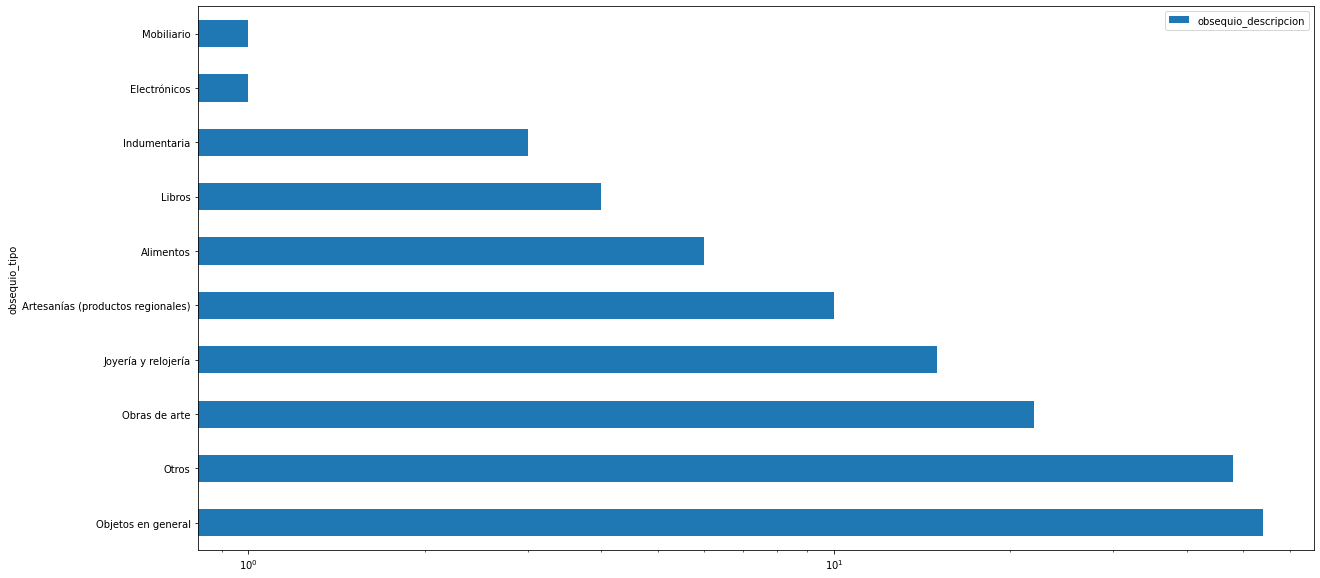

In [185]:
print("Cantidades de obsequios con un valor mayor a 4 módulos ($4.000)")
expensive_gifts = data[data.obsequio_valor_estimado=="Superior a 4 módulos o imposibilidad de determinar su valor."]

expensive_gifts_by_type = expensive_gifts[["obsequio_tipo", "obsequio_descripcion"]].groupby("obsequio_tipo").count().sort_values("obsequio_descripcion", ascending=False)

print(expensive_gifts_by_type)
expensive_gifts_by_type.plot(kind = 'barh', figsize=(20,10), logx=True)
plt.show()

In [186]:
# Create a function to clean gift descriptions
def cleanTxt(text):
 text = text.replace("inscripción provisoria por comunicación judicial (causa 9608/18 del juzg fed crim y corr 11) como fecha de recepción se indica la de dicha comunicación",'')
 text = text.replace(" -- ",'').replace("-",',').replace(" , ",', ')
 text = text.replace("\"",'')
 text = re.sub(r'\(([0-9]+)\)', '', text)
 text = re.sub(' +', ' ', text)
 text = text.strip()
 return text

# Clean gift descriptions
expensive_gifts["clean_obsequio_descripcion"] = expensive_gifts.obsequio_descripcion.apply(cleanTxt)

#print(expensive_gifts.clean_obsequio_descripcion.unique())

In [187]:
#tokenize gifts descriptions and remove spanish stopwords
nlp = Spanish(path=None)
#TODO consumir api de ML para obtener precio random de regalos?

for i in range(len(expensive_gifts)):
  gift = expensive_gifts[["clean_obsequio_descripcion"]].iloc[i][0]
  doc = nlp(gift)
  #tokens = [token.text for token in doc if not token.is_stop]
  tokens = [token for token in doc]
  print(tokens)

[bolígrafo, ,, montblanc, ,, pix, rollerball, blue, ,, serie, 114809, origen, :, alemania]
[alfombras]
[alfombra, fbmi, ,, modelo, sultan, mamluk]
[pañuelo, hermes, 90, cm, mythiques, phoenix, coloriages]
[una, tetera, de, porcelana, pintada, ,, cuatro, tazas, sin, asa, de, porcelana, pintada, ,, una, caramelera, de, porcelana]
[plato, de, porcelana, ,, elaborado, con, la, técnica, de, porcelana, tierna, ,, material, pasta, tierna, .]
[cafetera, clasica, de, la, hospitaridad, arabe, presentada, en, base, caoba]
[cuadro, de, estilo, abstracto]
[un, juego, de, té, de, porcelana, pintada, a, mano, compuesto, por, una, tetera, ,, un, plato, y, cinco, tacitas]
[un, cuadro, de, singapur, en, acuarela]
[un, centro, de, mesa, cuadrado, de, vidrio, con, flores]
[una, fuente, de, metal, plateado, con, la, casa, blanca, grabada]
[un, cuadro, de, la, universidad, de, pensilvania]
[un, cuadro, de, vidrio, con, la, imagen, de, un, caballo]
[una, billetera, color, bordeaux, salvatore, ferragamo]
[un,

In [188]:
stop_words = [token.text for token in doc if token.is_stop]
STOP_WORDS.update(stop_words)
print(STOP_WORDS.intersection(stop_words))

{'con', 'un', 'una', 'de'}


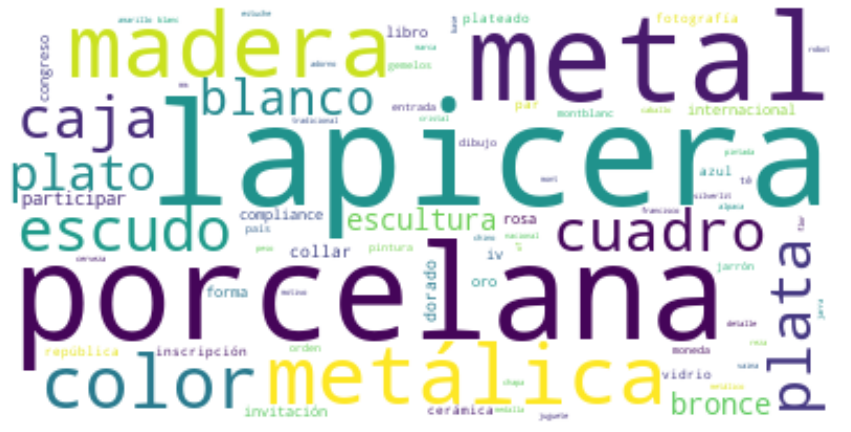

In [189]:
# word cloud visualization
allWords = ' '.join(expensive_gifts.clean_obsequio_descripcion)

wordCloud = WordCloud(background_color="white", random_state=21, stopwords=STOP_WORDS, collocations=False)

wordCloud.generate(allWords)

#show
plt.figure(figsize=(15,8))
plt.imshow(wordCloud, interpolation="bilinear")
plt.axis('off')
plt.show()

#store to file
#wordCloud.to_file(path.join(d, "christmas_for_politicians.png"))

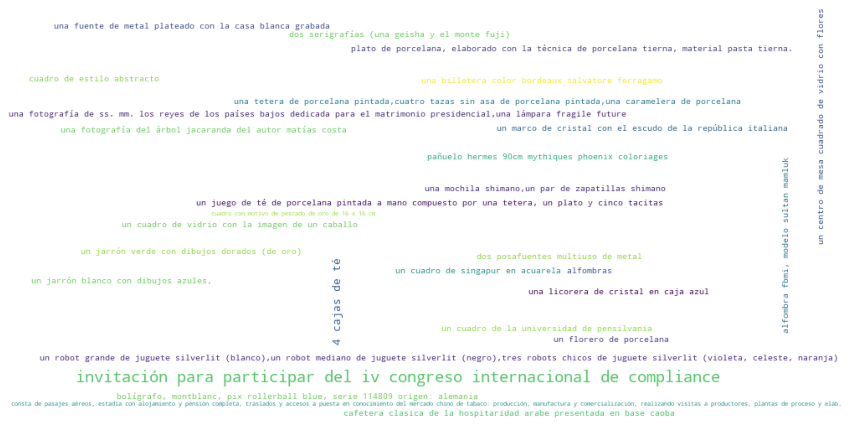

In [190]:
#generate wordCloud from full gift description
word_could_dict = Counter(expensive_gifts.clean_obsequio_descripcion)
make_wordcloud(dict(word_could_dict.most_common(30)))
#use it to save wordcloud as a file
#make_wordcloud(dict(word_could_dict.most_common(30)), "gifts_wordCloud_from_frequencies")